# Algorithmic trading of Apple Stock with Keras (using LSTM)

We use a Long Short Time Memory recurrent neural network to develop a good trading strategy for Apple stock: the opening price for each day we want our model to tell us if we are going to stay in the market for that day or not.

We thencompare this LSTM-trading-strategy to: (1) a buy and hold strategy (stay always in the market) and (2) a moving average strategy (buy when the current price is greater or equal to the moving average of past 50 days and sell otherwise).

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

## Part 1: Get the data 

We used Yahoo Finance to get the data for Apple stock from 2016/1/6 to 2021/1/5. Our analysis is daily-based, and all the decisions are made using the open price on each day.

For a reason which will be clarified by the following code, our analysis will start from 50 days after January 6, 2016 and end the day before January 5, 2021.

We used Yahoo Finance and DataReader to obtain and load trading data for Apple stock.

In [2]:
# Identify stock data to grab by ticker
ticker = 'AAPL'

start_date=datetime.datetime(2016,1,6)
end_date=datetime.datetime(2021,1,5)

# df=pd.read_csv("AAPL.csv")
# df.index=pd.to_datetime(df["Date"])
# df=df.drop("Date",axis=1)

In [3]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader

df = DataReader(ticker, 'yahoo', start_date, end_date)

df.drop("Adj Close",axis=1,inplace=True) # May have to adjut columns later

Now for each day we have the closing price for the day, the open price for the day (proxy for the closing price of the previous day) and the open price of the following day.

The feature *rapp* is the quotient between the open and closing prices of the day. It will be used because it gives the variation of the portfolio for the day.

In [4]:
df['Prev_Close']=df['Close'].shift(1)
df.head()

,High,Low,Open,Close,Volume,Prev_Close
Date,,,,,,
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,NaN
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,25.174999
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,24.112499
2016-01-11,24.764999,24.334999,24.742500,24.632500,198957600.0,24.240000
2016-01-12,25.172501,24.709999,25.137501,24.990000,196616800.0,24.632500


In [5]:
df["rapp"]=df["Close"].divide(df['Close'].shift(1)) # Should be the close of the previous close

In [6]:
df.head(10)

,High,Low,Open,Close,Volume,Prev_Close,rapp
Date,,,,,,,
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,NaN,NaN
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,25.174999,0.957795
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,24.112499,1.005288
2016-01-11,24.764999,24.334999,24.742500,24.632500,198957600.0,24.240000,1.016192
2016-01-12,25.172501,24.709999,25.137501,24.990000,196616800.0,24.632500,1.014513
2016-01-13,25.297501,24.325001,25.080000,24.347500,249758400.0,24.990000,0.974290
2016-01-14,25.120001,23.934999,24.490000,24.879999,252680400.0,24.347500,1.021871
2016-01-15,24.427500,23.840000,24.049999,24.282499,319335600.0,24.879999,0.975985
2016-01-19,24.662500,23.875000,24.602501,24.165001,212350800.0,24.282499,0.995161


In [7]:
print(df.head())
print(df.tail())

                 High        Low       Open      Close       Volume  \
Date                                                                  
2016-01-06  25.592501  24.967501  25.139999  25.174999  273829600.0   
2016-01-07  25.032499  24.107500  24.670000  24.112499  324377600.0   
2016-01-08  24.777500  24.190001  24.637501  24.240000  283192000.0   
2016-01-11  24.764999  24.334999  24.742500  24.632500  198957600.0   
2016-01-12  25.172501  24.709999  25.137501  24.990000  196616800.0   

            Prev_Close      rapp  
Date                              
2016-01-06         NaN       NaN  
2016-01-07   25.174999  0.957795  
2016-01-08   24.112499  1.005288  
2016-01-11   24.240000  1.016192  
2016-01-12   24.632500  1.014513  
                  High         Low        Open       Close       Volume  \
Date                                                                      
2020-12-29  138.789993  134.339996  138.050003  134.869995  121047300.0   
2020-12-30  135.990005  133.3999

Now we add the columns corresponding to the moving averages at 5 and 50 days

In [8]:
# Should we be shifting 1?

# df["mv_avg_short"]= df["Close"].rolling(window=5).mean().shift(1)
# df["mv_avg_long"]= df["Close"].rolling(window=50).mean().shift(1)

df["mv_avg_short"]= df["Close"].rolling(window=5).mean()
df["mv_avg_long"]= df["Close"].rolling(window=50).mean()

In [9]:
df.head()

,High,Low,Open,Close,Volume,Prev_Close,rapp,mv_avg_short,mv_avg_long
Date,,,,,,,,,
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,NaN,NaN,NaN,NaN
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,25.174999,0.957795,NaN,NaN
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,24.112499,1.005288,NaN,NaN
2016-01-11,24.764999,24.334999,24.742500,24.632500,198957600.0,24.240000,1.016192,NaN,NaN
2016-01-12,25.172501,24.709999,25.137501,24.990000,196616800.0,24.632500,1.014513,24.63,NaN


In [10]:
print(df.loc["2020-12","mv_avg_short"])
print(df.loc["2019-12":"2020-11","Open"])
print(df.loc["2019-12":"2020-11","Open"].mean())

Date
2020-12-01    117.912000
2020-12-02    119.494000
2020-12-03    120.876001
2020-12-04    122.008002
2020-12-07    122.948001
2020-12-08    123.280000
2020-12-09    123.020000
2020-12-10    123.079999
2020-12-11    123.112000
2020-12-14    122.717999
2020-12-15    123.417999
2020-12-16    124.623999
2020-12-17    125.715999
2020-12-18    126.565999
2020-12-21    127.855998
2020-12-22    128.656000
2020-12-23    129.286002
2020-12-24    129.940002
2020-12-28    131.946002
2020-12-29    133.274002
2020-12-30    133.642001
2020-12-31    133.988000
Name: mv_avg_short, dtype: float64
Date
2019-12-02     66.817497
2019-12-03     64.577499
2019-12-04     65.267502
2019-12-05     65.947502
2019-12-06     66.870003
                 ...    
2020-11-23    117.180000
2020-11-24    113.910004
2020-11-25    115.550003
2020-11-27    116.570000
2020-11-30    116.970001
Name: Open, Length: 252, dtype: float64
90.28259932805621


We remove the first 50 days, since they do not have the 50-day moving average

In [11]:
df=df.iloc[50:,:] # WARNING: DO IT JUST ONE TIME!
print(df.index)

DatetimeIndex(['2016-03-18', '2016-03-21', '2016-03-22', '2016-03-23',
               '2016-03-24', '2016-03-28', '2016-03-29', '2016-03-30',
               '2016-03-31', '2016-04-01',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
               '2021-01-04', '2021-01-05'],
              dtype='datetime64[ns]', name='Date', length=1209, freq=None)


Finally, we can divide *df* in train and test set

In [12]:
mtest=300
train=df.iloc[:-mtest,:] 
test=df.iloc[-mtest:,:] 

In [13]:
print(len(train))
print(len(test))
print(len(df))

909
300
1209


## Part 2: Define functions to compute gross and net yield

Notice that the gross yield can be computed very easily using the feature *rapp*.
The following function explains how: the vector v selects which months we are going to stay in the market

In [14]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/252
    return (prod-1)*100,((prod**(1/n_years))-1)*100

## Part 3: Define the LSTM model

In [15]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [16]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(df[["High","Low","Open","Close","Volume",\
                                          "mv_avg_short","mv_avg_long"]].values))
dg0=dg[[0,1,2,3,4,5]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,6))

y_dfw=np.array(dg[6][window:]) # The Fix

In [17]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

In [18]:
def model_lstm(window,features):
    
    model=Sequential()
#     model.add(LSTM(600, input_shape = (window,features), return_sequences=True))
#     model.add(Dropout(0.5))
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

Epoch 1/100
31/31 [==============================] - 3s 41ms/step - loss: 0.0022 - val_loss: 0.0942
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0108 - val_loss: 0.1469
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0041 - val_loss: 0.0748
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0061 - val_loss: 0.0567
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0053 - val_loss: 0.0860
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 9.5374e-04 - val_loss: 0.1053
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 8.9784e-04 - val_loss: 0.1016
Epoch 8/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.1170
Epoch 9/100
31/31 [==============================] - 1s 18ms/step - loss: 8.2743e-04 - val_loss: 0.1211
Epoch 10/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0010 - val_

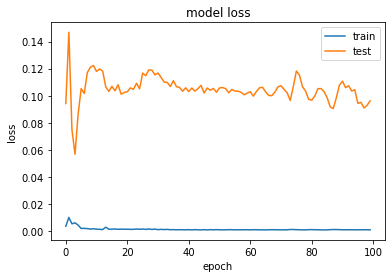

In [19]:
model=model_lstm(window+1,6)
history=model.fit(X_trainw,y_trainw,epochs=100, batch_size=30, validation_data=(X_testw, y_testw), \
                  verbose=1, callbacks=[],shuffle=False) # Batch size should be no more than the square root of the # of training rows

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
y_pr=model.predict(X_trainw)

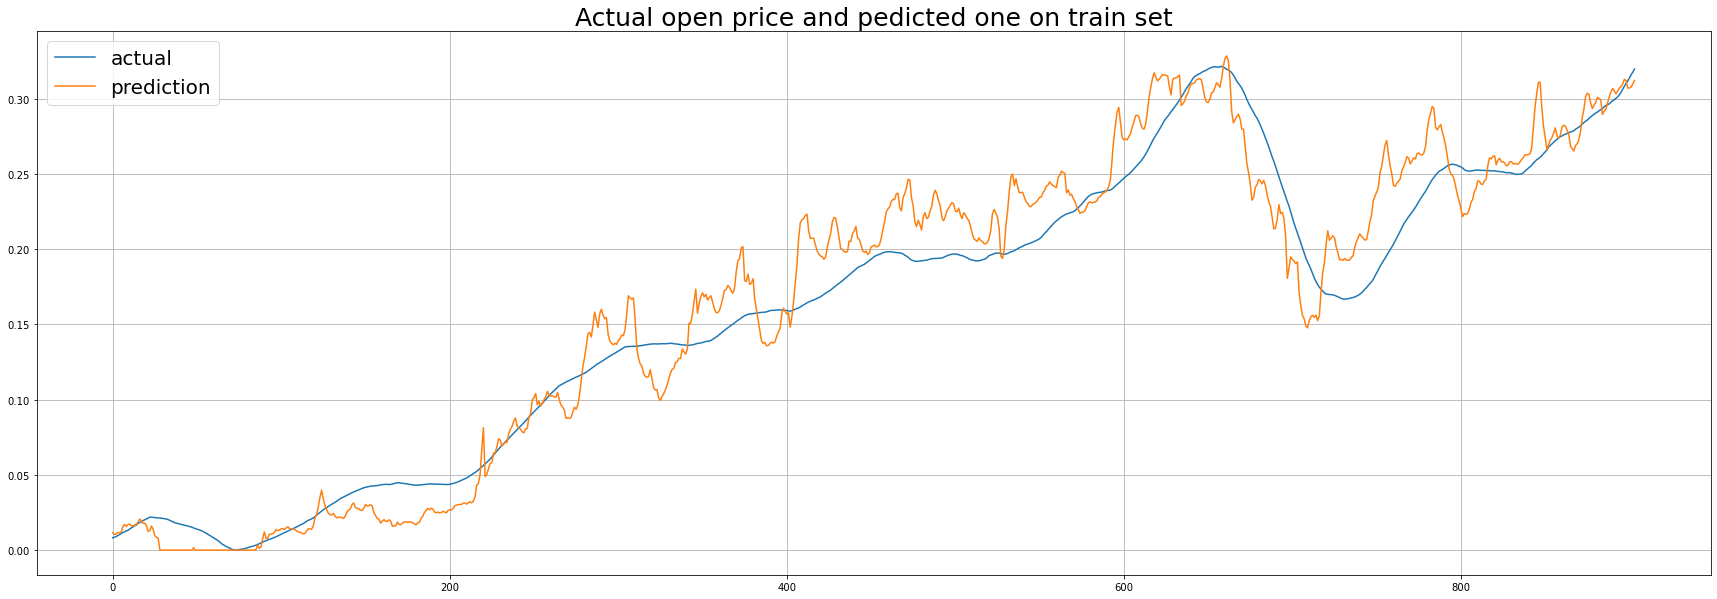

In [21]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [22]:
y_pred=model.predict(X_testw)

**We stay in the market when the predicted price for the day's close is greater than the current day's openning price and stay out otherwise. The vector v indicates the "in days" (as 1s) and "out days" (as 0s)**

In [23]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm=np.maximum(np.sign(v),0)

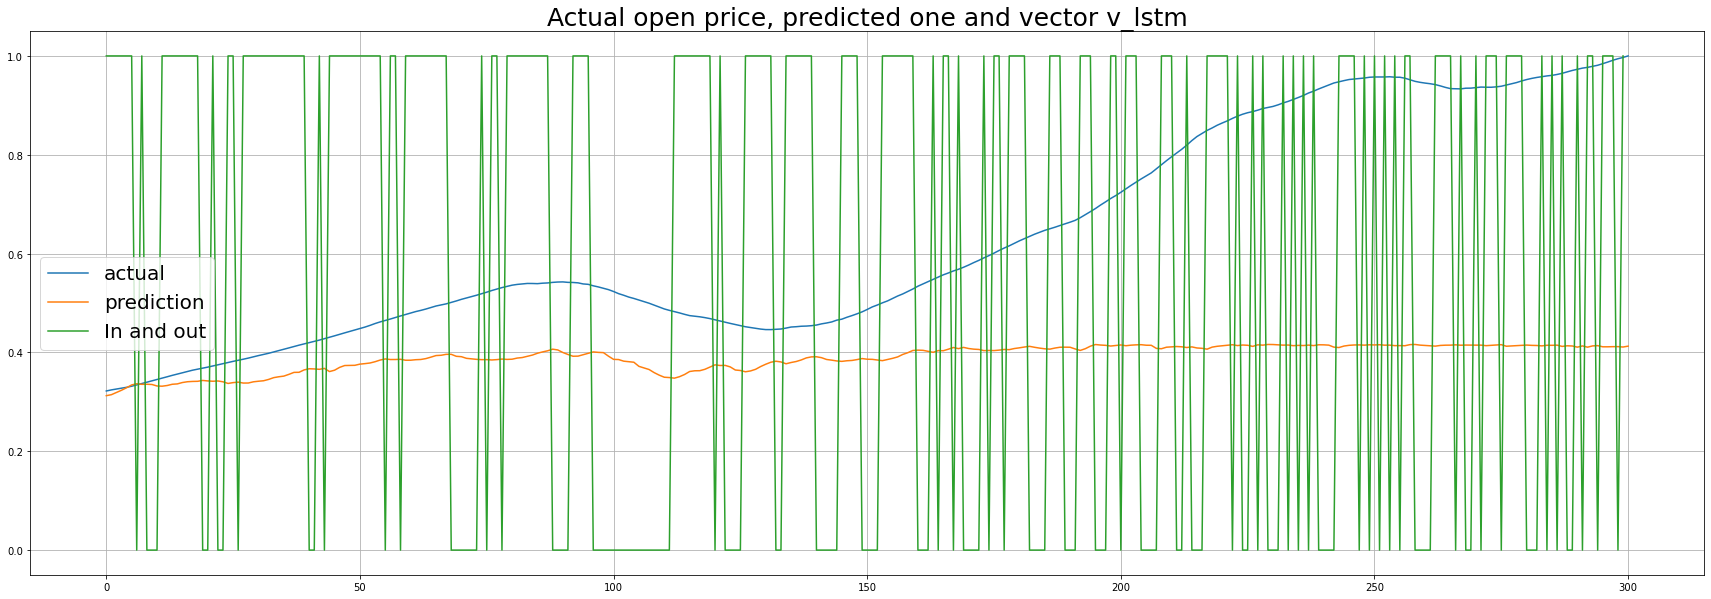

In [24]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

## Part 4: Compare the LSTM method with other methods

Now we can copare our LSTM-trading-strategy with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [25]:
v_bh=np.ones(test.shape[0])
v_ma=test["Open"]>test["mv_avg_short"]

In [26]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

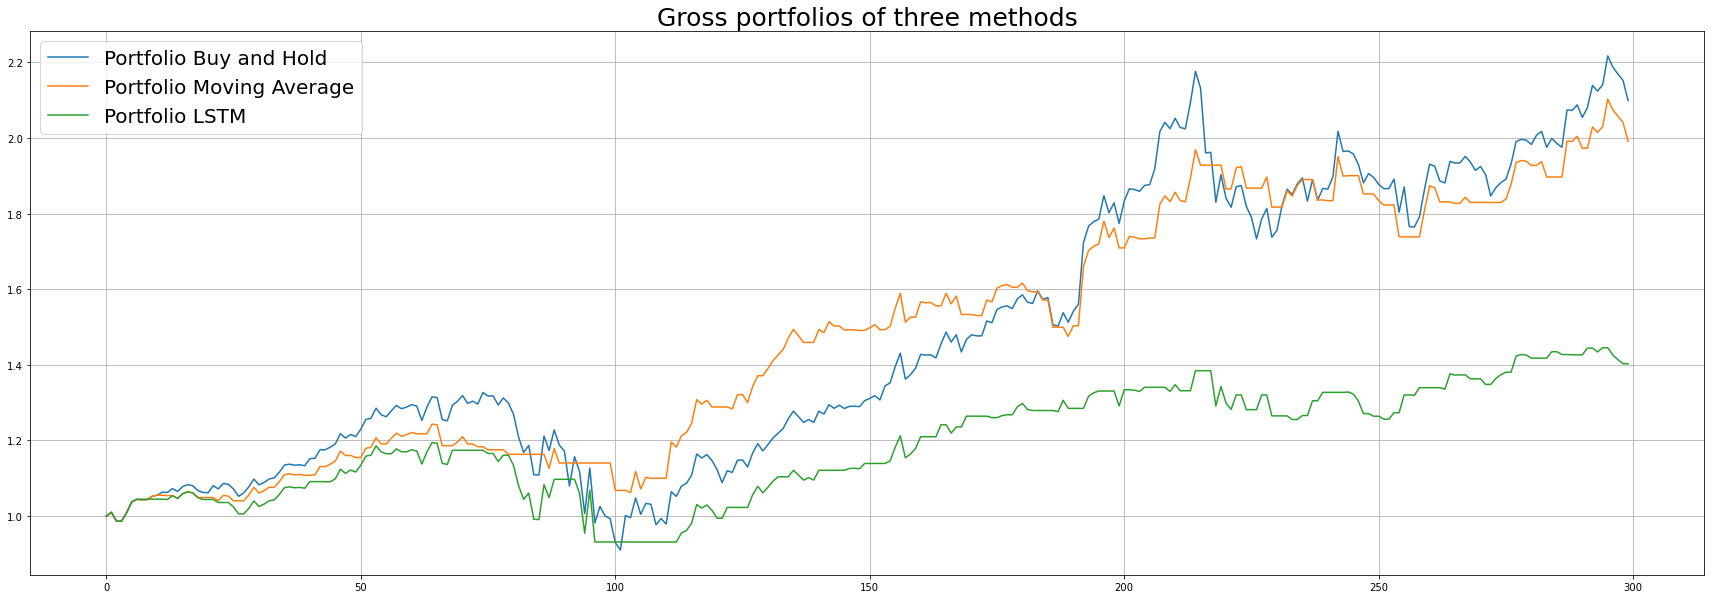

In [27]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [28]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/365,str(test.loc[test.index[0],"Open"])[:10],\
      str(test.loc[test.index[-1],"Close"])[:10]))

results0=pd.DataFrame({})
results1=pd.DataFrame({})

results0["Method"]=["Buy and hold","Moving average","LSTM"]
results1["Method"]=["Buy and hold","Moving average","LSTM"]

vs=[v_bh,v_ma,v_lstm]
results0["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results1["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]

print(results0)
print("\n")
print(results1)

Test period of 0.82 years, from 61.8549995 to 131.009994 

           Method Total gross yield
0    Buy and hold          112.52 %
1  Moving average           99.12 %
2            LSTM           42.03 %


           Method Annual gross yield
0    Buy and hold            88.37 %
1  Moving average            78.34 %
2            LSTM            34.28 %


In [29]:
#            Method Annual gross yield
# 0    Buy and hold            88.37 %
# 1  Moving average           147.07 %
# 2            LSTM            69.87 %